# Data Generation
Heston Model:
$$dS_{t}={\sqrt  {V _{t}}}S_{t}\,dW_{t}, \ S_{0}=s_{0}>0$$
$$dV _{t}=a (b -V _{t})\,dt+c {\sqrt  {V _{t}}}\,dZ_{t}, \ V_{0}=v_{0}>0$$
Model Parameters: 
$$\theta = (a,b,c,\rho)$$

SABR Model:
$$dS_{t}=V_{t}S_{t}^{\beta }\,dW_{t}, \ S_{0}=s_{0}>0,  \ \beta \in [0,1]$$
$$dV_{t}=\alpha V_{t}^{}\,dZ_{t}, \ V_{0}=v_{0}>0$$
Model Parameters:
$$\theta = (\alpha,\beta,\rho)$$

Approch: Simulate market S for different parameters using Euler-Maruyama

Goal: function with input: $$\theta$$ and output: $$S(\{(strikes,maturities)\})$$

## Brownian Motion

In [18]:
from math import sqrt
from scipy.stats import norm
import numpy as np

In [19]:
def brownian_motion(n, T, dim, out=None):
    dt = T/n
    
    r = norm.rvs(size=(dim,n+1) , scale=sqrt(dt))

    if out is None:
        out = np.zeros((dim,n+1))
        
    np.cumsum(r, axis=-1, out=out)
 
    return out

In [126]:
n=1000
T=2
dim=8

bm = brownian_motion(n,T,dim)
bm.shape

(8, 1001)

In [127]:
import matplotlib.pyplot as plt

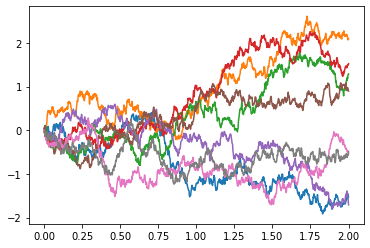

In [128]:
for k in range(dim):    
    plt.plot(np.linspace(0,T,n+1), bm[k,:])    


## Correlated Brownian Motion

In [220]:
def corr_brownian_motion(n, T, dim, rho):
    dt = T/n

    dW1 = norm.rvs(size=(dim,n+1) , scale=sqrt(dt))
    dW2 = rho * dW1 + np.sqrt(1 - np.power(rho ,2)) * norm.rvs(size=(dim,n+1) , scale=sqrt(dt))
        
    W1 = np.cumsum(dW1, axis=-1)
    W2 = np.cumsum(dW2, axis=-1)
 
    return W1,W2

In [221]:
n=1000
T=2
dim=2
rho=-1

W,Z = corr_brownian_motion(n,T,dim,rho)
W.shape

(2, 1001)

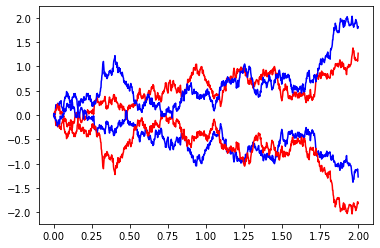

In [223]:
for k in range(dim):    
    plt.plot(np.linspace(0,T,n+1), W[k,:], "r") 
    plt.plot(np.linspace(0,T,n+1), Z[k,:], "b") 

## Euler Maruyama and Milstein

For $${\mathrm  {d}}X_{t}=\mu(X_{t})\,{\mathrm  {d}}t+\sigma(X_{t})\,{\mathrm  {d}}W_{t}$$
the Euler Maruyama method reads: $$\,Y_{{n+1}}=Y_{n}+\mu(Y_{n})\,\Delta t+\sigma(Y_{n})\,(W_{{\tau _{{n+1}}}}-W_{{\tau _{n}}})\, \ 
with \ Y_{{0}} = X_{{0}}$$

In [73]:
from scipy.stats import norm
import numpy as np

In [168]:
def euler_maruyama(mu,sigma,T,x0,W):
    dim = W.shape[0]
    n = W.shape[1]-1
    Y = np.zeros((dim,n+1))
    dt = T/n
    sqrt_dt = np.sqrt(dt)
    for l in range(dim):
        Y[l,0] = x0
        for i in range(n):
            Y[l,i+1] = Y[l,i] + mu(Y[l,i],l,i)*dt + sigma(Y[l,i],l,i)*sqrt_dt*(W[l,i+1]-W[l,i])
    
    return Y

The Milstein method reads: $$\,Y_{{n+1}}=Y_{n}+\mu(Y_{n})\,\Delta t+\sigma(Y_{n})\,(W_{{\tau _{{n+1}}}}-W_{{\tau _{n}}}) +{\frac {1}{2}}\sigma(Y_{n})\sigma'(Y_{n})\left((W_{{\tau _{{n+1}}}}-W_{{\tau _{n}}})^{2}-\Delta t\right)\, \ 
with \ Y_{{0}} = X_{{0}}$$


In [169]:
def milstein(mu,sigma,sigma_derivative,T,x0,W):
    dim = W.shape[0]
    n = W.shape[1]-1
    Y = np.zeros((dim,n+1))
    dt = T/n
    sqrt_dt = np.sqrt(dt)
    for l in range(dim):
        Y[l,0] = x0
        for i in range(n):
            Y[l,i+1] = Y[l,i] + mu(Y[l,i],l,i)*dt + np.multiply(sigma(Y[l,i],l,i)*sqrt_dt,(W[l,i+1]-W[l,i]))+0.5*sigma(Y[l,i],l,i)*sigma_derivative(Y[l,i],l,i)*((W[l,i+1]-W[l,i])^2-dt)
    
    return Y

## Heston Model

In [170]:
#work in progress
def heston(a,b,c,T,W,Z,V0,S0):
    assert(2*a*b > c*c)
    
    def mu2(V,i,k):
        return a*(b-V)
    
    def sigma2(V,i,k):
        return c*np.sqrt(np.maximum(0.0,V))
    
    V = euler_maruyama(mu2,sigma2,T,V0,Z)
    
    def mu1(S,i,k):
        return 0.0
    
    def sigma1(S,i,k):
        return np.sqrt(np.maximum(0.0,V[i,k]))*S
    
    S = euler_maruyama(mu1,sigma1,T,S0,W)
    
    return S,V
    

### Test

1.057866292505528
3.992028317472154


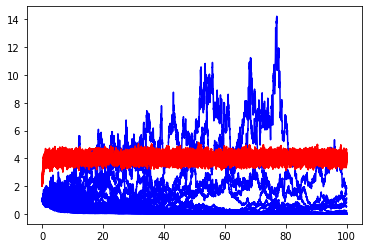

In [227]:
a=3
b=4
c=2
T=100
n=5000
dim=50
rho=-0.5

W,Z = corr_brownian_motion(n,T,dim,rho)
V0 = 2
S0 = 1

S,V = heston(a,b,c,T,W,Z,V0,S0)
S_T = S[:,T]
V_T = V[:,T]
S_T_mean = np.mean(S_T, axis=0)
V_T_mean = np.mean(V_T, axis=0)


print(S_T_mean)
print(V_T_mean)

for k in range(dim):    
    plt.plot(np.linspace(0,T,n+1), V[k,:],"r") 
    plt.plot(np.linspace(0,T,n+1), S[k,:], "b") 

Note: S_T (blue) does not seem to converge, something probably wrong

Also: V seems to converge towards b, while S stays close to one(probably wrong)

## SABR Model

In [157]:
#work in progress

In [190]:
def sabr(alpha,beta,T,W,Z,V0,S0):
    assert(beta>0 and beta<1)

    def mu2(V,i,k):
        return 0.0
    
    def sigma2(V,i,k):
        return alpha*V
    
    V = euler_maruyama(mu2,sigma2,T,V0,Z)
    
    def mu1(S,i,k):
        return 0.0
    
    def sigma1(S,i,k):
        return V[i,k]*np.power(np.maximum(0.0,S),beta)
    
    S = euler_maruyama(mu1,sigma1,T,S0,W)
    
    return S,V

### Test

7.75670637182821
2.5058897319589963


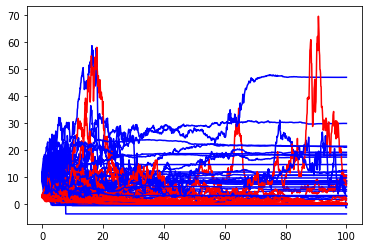

In [194]:
alpha=1
beta=0.5
T=100
n=1000
dim=50
W=brownian_motion(n,T,dim)
Z=brownian_motion(n,T,dim)
V0 = 3
S0 = 10

S,V = sabr(alpha,beta,T,W,Z,V0,S0)
S_T = S[:,T]
V_T = V[:,T]
S_T_mean = np.mean(S_T, axis=0)
V_T_mean = np.mean(V_T, axis=0)


print(S_T_mean)
print(V_T_mean)

for k in range(dim):    
    plt.plot(np.linspace(0,T,n+1), V[k,:], "r") 
    plt.plot(np.linspace(0,T,n+1), S[k,:], "b") 

## Actually Generate Data

Generate grid of input data. Use Pandas to write  data to csv

In [110]:
import pandas as pd

In [148]:
#to ensure 2ab > c^2 let's use a,b~Uni(1,2) and c~Uni(0,1)
from scipy.stats import uniform

num_parameters = 3
sigma = np.array((num_parameters,None))
